# How generalizable are the training models?

It would be very convenient

In [42]:
import pandas as pd
import numpy as np
import os
import pickle
from scipy.stats.mstats import zscore
import time
from datetime import date
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()
%matplotlib inline

In [43]:
with open('holidays.pickle', 'rb') as f:
    nerc6 = pickle.load(f)

def MAPE(predictions, answers):
    # THIS IS PROBLEMATIC IF Y is EVER 0
    assert len(predictions) == len(answers)
    return sum([abs(x-y)/(y+1e-5) for x, y in zip(predictions, answers)])/len(answers)*100 

def isHoliday(holiday, df):
    # New years, memorial, independence, labor day, Thanksgiving, Christmas
    m1 = None
    if holiday == "New Year's Day":
        m1 = (df["dates"].dt.month == 1) & (df["dates"].dt.day == 1)
    if holiday == "Independence Day":
        m1 = (df["dates"].dt.month == 7) & (df["dates"].dt.day == 4)
    if holiday == "Christmas Day":
        m1 = (df["dates"].dt.month == 12) & (df["dates"].dt.day == 25)
    m1 = df["dates"].dt.date.isin(nerc6[holiday]) if m1 is None else m1
    m2 = df["dates"].dt.date.isin(nerc6.get(holiday + " (Observed)", []))
    return m1 | m2

def makeUsefulDf(df):
    """
    Turn a dataframe of datetime and load data into a dataframe useful for
    machine learning. Normalize values and turn 
    Features are placed into r_df (return dataframe), creates the following columns

        YEARS SINCE 2000

        LOAD AT THIS TIME DAY BEFORE

        HOUR OF DAY
        - is12AM (0, 1)
        - is1AM (0, 1)
        ...
        - is11PM (0, 1)

        DAYS OF THE WEEK
        - isSunday (0, 1)
        - isMonday (0, 1)
        ...
        - isSaturday (0, 1)

        MONTHS OF THE YEAR
        - isJanuary (0, 1)
        - isFebruary (0, 1)
        ...
        - isDecember (0, 1)

        TEMPERATURE
        - Celcius (normalized from -1 to 1)

        PREVIOUS DAY'S LOAD 
        - 12AM of day previous (normalized from -1 to 1)
        - 1AM of day previous (normalized from -1 to 1)
        ...
        - 11PM of day previous (normalized from -1 to 1)

        HOLIDAYS (the nerc6 holidays)
        - isNewYears (0, 1)
        - isMemorialDay (0, 1)
        ...
        - is Christmas (0, 1)

    """

    def _normalizeCol(l):
        #s = l.max() - l.min()
        #return l if s == 0 else (l - l.mean()) / l.std()
        return zscore(l)
    def _chunks(l, n):
        return [l[i : i + n] for i in range(0, len(l), n)]

    r_df = pd.DataFrame()
    r_df["load_n"] = _normalizeCol(df["load"])
    r_df["years_n"] = _normalizeCol(df["dates"].dt.year - 2000)

    # fix outliers
    m = df["tempc"].replace([-9999], np.nan)
    m.ffill(inplace=True)
    # 2.5 degrees average std error for the national weather service
    temp_noise = m
    r_df["temp_n"] = _normalizeCol(temp_noise)
    r_df['temp_n^2'] = r_df["temp_n"]**2

    # add the value of the load 24hrs before
    r_df["load_prev_n"] = r_df["load_n"].shift(24)
    r_df["load_prev_n"].bfill(inplace=True)

    # create day of week vector
    r_df["day"] = df["dates"].dt.dayofweek  # 0 is Monday.
    w = ["S", "M", "T", "W", "R", "F", "A"]
    for i, d in enumerate(w):
        r_df[d] = (r_df["day"] == i).astype(int)

        # create hour of day vector
    r_df["hour"] = df["dates"].dt.hour
    d = [("h" + str(i)) for i in range(24)]
    for i, h in enumerate(d):
        r_df[h] = (r_df["hour"] == i).astype(int)

        # create month vector
    r_df["month"] = df["dates"].dt.month
    y = [("m" + str(i)) for i in range(12)]
    for i, m in enumerate(y):
        r_df[m] = (r_df["month"] == i).astype(int)

        # create 'load day before' vector
    n = np.array([val for val in _chunks(list(r_df["load_n"]), 24) for _ in range(24)])
    l = ["l" + str(i) for i in range(24)]
    for i, s in enumerate(l):
        r_df[s] = n[:, i]

        # create holiday booleans
    r_df["isNewYears"] = isHoliday("New Year's Day", df)
    r_df["isMemorialDay"] = isHoliday("Memorial Day", df)
    r_df["isIndependenceDay"] = isHoliday("Independence Day", df)
    r_df["isLaborDay"] = isHoliday("Labor Day", df)
    r_df["isThanksgiving"] = isHoliday("Thanksgiving", df)
    r_df["isChristmas"] = isHoliday("Christmas Day", df)

    m = r_df.drop(["month", "hour", "day", "load_n"], axis=1)
    return m

def neural_net_predictions(all_X, all_y):
    import tensorflow as tf
    from tensorflow.keras import layers
    tic = time.time()
    X_train, y_train = all_X[:-8760], all_y[:-8760]

    model = tf.keras.Sequential([
        layers.Dense(all_X.shape[1], activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
        layers.Dense(all_X.shape[1], activation=tf.nn.relu),
        layers.Dense(all_X.shape[1], activation=tf.nn.relu),
        layers.Dense(all_X.shape[1], activation=tf.nn.relu),
        layers.Dense(all_X.shape[1], activation=tf.nn.relu),
        layers.Dense(1)
      ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(
        loss="mean_squared_error",
        optimizer=optimizer,
        metrics=["mean_absolute_error", "mean_squared_error"],
    )

    EPOCHS = 100

    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

    history = model.fit(
        X_train,
        y_train,
        epochs=EPOCHS,
        validation_split=0.2,
        verbose=0,
        callbacks=[early_stop],
    )
    
    def MAPE(predictions, answers):
        # THIS IS PROBLEMATIC IF Y is EVER 0
        assert len(predictions) == len(answers)
        return sum([abs(x-y)/(y+1e-5) for x, y in zip(predictions, answers)])/len(answers)*100   
    
    predictions = [float(f) for f in model.predict(all_X[-8760:])]
    train = [float(f) for f in model.predict(all_X[:-8760])]
    accuracy = {
        'test': MAPE(predictions, all_y[-8760:]),
        'train': MAPE(train, all_y[:-8760])
    }
    
    return predictions, accuracy, time.time() - tic, model

In [44]:
df = pd.read_csv('data/test/NCENT.csv', parse_dates=['dates'])
all_X = makeUsefulDf(df)
all_y = df['load']
predictions, accuracy, t, model = neural_net_predictions(all_X, all_y)
print(accuracy, t)

{'test': 1.0415132211779974, 'train': 0.8895285582881018} 229.6786937713623


In [46]:
df_results = pd.DataFrame()
for f in os.listdir('data/test'):
    if f.endswith('.csv'):
        df_t = pd.read_csv('data/test/' + f, parse_dates=['dates'])
        all_X = makeUsefulDf(df_t)
        all_y = df_t['load']
        predictions = [float(f) for f in model.predict(all_X[-8760:])]
        answers = all_y[-8760:]
        df_results['{}-pred'.format(f[:-4])] = predictions
        df_results['{}-ans'.format(f[:-4])] = [float(f) for f in answers]
        print(f, MAPE(predictions, answers))

SCENT.csv 102.1099221060264
NCENT.csv 1.0415132211779974
COAST.csv 17.470090937276446
FWEST.csv 606.5166585054774
EAST.csv 796.5769107132209
SOUTH.csv 322.9595509845822
NORTH.csv 1184.785534922244
WEST.csv 1123.2375785765555


In [47]:
df_results.head()

SCENT-pred    SCENT-ans    NCENT-pred     NCENT-ans    COAST-pred  \
0  18544.691406  9151.190703  18279.148438  18584.343617  13420.492188   
1  18183.421875  9144.993712  18122.216797  18524.141392  13156.949219   
2  18260.607422  9141.036615  18058.738281  18532.056616  13076.198242   
3  18329.822266  9157.956866  18258.302734  18647.444612  13199.899414   
4  18762.646484  9214.333628  18675.505859  19002.102222  13432.152344   

      COAST-ans    FWEST-pred    FWEST-ans     EAST-pred     EAST-ans  \
0  11425.979115  20048.609375  2823.409245  17030.300781  1852.663959   
1  11408.418023  19533.884766  2809.745403  16959.171875  1850.169452   
2  11405.198365  19421.310547  2797.802576  16979.980469  1858.269586   
3  11450.560138  19574.775391  2807.793880  17150.685547  1879.623596   
4  11631.337459  19937.636719  2822.989206  17387.142578  1876.481320   

     SOUTH-pred    SOUTH-ans    NORTH-pred    NORTH-ans     WEST-pred  \
0  16400.505859  3831.649454  14531.651367  1135.360907  22167.023438   
1  16402.349609  3988.271046  14160.225586  1136.630855  21969.843750   
2  16648.125000  4076.086451  14175.176758  1135.930264  22067.322266   
3  16828.031250  4154.939804  14267.158203  1146.069491  22244.080078   
4  17199.052734  4247.451523  14755.545898  1154.186967  22471.859375   

      WEST-ans  
0  1762.472684  
1  1754.718094  
2  1747.919615  
3  1755.203307  
4  1774.849690

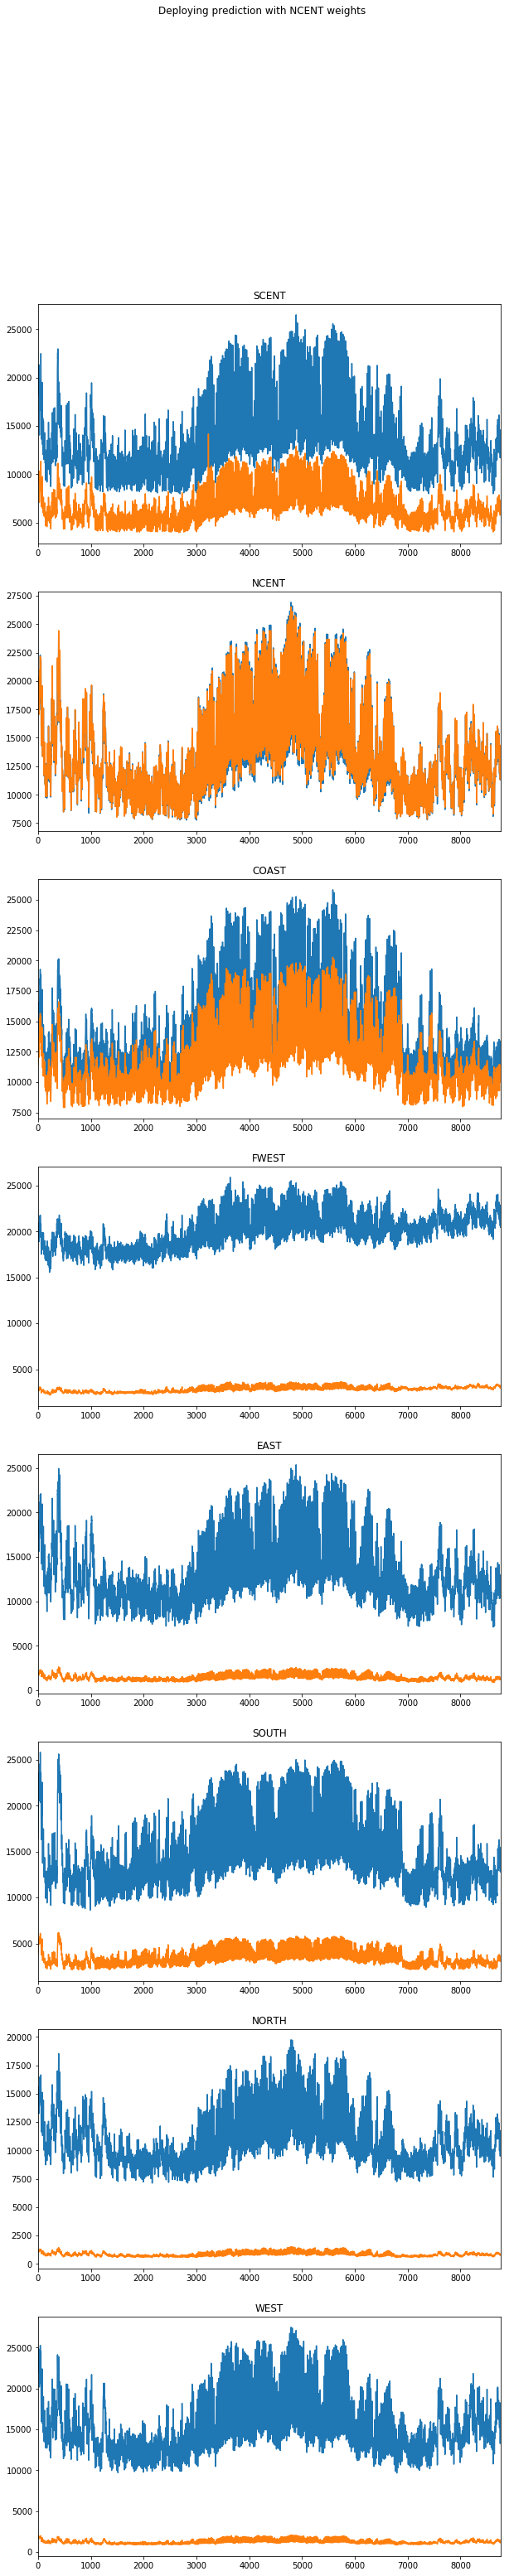

In [55]:
N = 8
fig, axes = plt.subplots(nrows=N, ncols=1, figsize=(10, 50))
i = 0
fig.suptitle('Deploying prediction with NCENT weights')
for f in os.listdir('data/test'):
    if f.endswith('.csv'):
        reg = f[:-4]
        df_results['{}-pred'.format(reg)].plot(ax=axes[i])
        df_results['{}-ans'.format(reg)].plot(ax=axes[i])
        axes[i].set_title(reg)
        i += 1
plt.savefig('generalized.png')